### Costa Rica Institute of Technology (TEC) 
### Colibri-ITCR 
### Project: Essential Biodiversity Variables: Extracting Plant Phenological Data from Specimen Labels Using Machine Learning
#### Multi-Label Text Classification

**María Auxiliadora Mora-Cross. January 2022**

Multi-Label Text Classification using herbarium specimen data from the National Biodiversity Institute of Costa Rica (INBio). The results of the project are described in the publication "Essential Biodiversity Variables: Extracting Plant Phenological Data from Specimen Labels Using Machine Learning" (Mora-Cross et al., 2022). The data and code used to achieve the goals of the project are available at https://github.com/colibri-itcr

Essential Biodiversity Variables (EBVs) make it possible to evaluate and monitor the state
of biodiversity over time and at different spatial scales. Its development is led by the Group on Earth Observations Biodiversity Observation Network (GEO BON) to harmonize,
consolidate, and standardize biodiversity data from varied biodiversity sources. This
document presents a mechanism to get baseline data to feed the Species Traits Variable
Phenology or other biodiversity indicators by ***classifying the specimens' morphological descriptions using machine learning (ML)***.

A workflow that performs Classification of morphological descriptions using ML algorithms was evaluated with excellent results. It was implemented using Python, Pytorch, Scikit-Learn, and other libraries applied to 106,804 herbarium records from the National Biodiversity Institute of Costa Rica (INBio). The text classification results were almost excellent (F1 score between 96% and 99%) using three traditional ML methods: Multinomial Naive Bayes (NB), Linear Support Vector Classification (SVC), and Logistic Regression (LR). 

Two classes were recognized has-flower and has-fruit each sample can be labeled with 0 or both classes. The experiments use multi-label classification and 10-fold cross validation to test the models.


In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean

# visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot

# machine learning algorithms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# NLP
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

# metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [2]:
# Read data
df = pd.read_csv("data/spec_multiLabel_rio.csv", encoding = "ISO-8859-1")
print(df.shape)
print(df.columns)

(106804, 4)
Index(['specimen_id', 'contents', 'has_flower', 'has_fruit'], dtype='object')


In [3]:
# Checking missing contents in morphological descriptions.
print('Number of missing comments in comment text:')
df['contents'].isnull().sum()

Number of missing comments in comment text:


0

In [4]:
# Utility functions

def evaluate_model_crossValidation(cv, model, X, y):
    """ 
    Evaluate a model using a given test condition
    :param cv test conditions to use in cross validation.
    :param model to test
    :param X (features).
    :param y (target).
    Return a the mean of accuracy, precision, recall y f1 score for cv validations of the model.     
    """ 
    # evaluate the model
    scores_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    scores_f1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    # return the mean of scores
    return mean(scores_accuracy), mean(scores_precision), mean(scores_recall), mean(scores_f1) 



In [5]:
## Number of specimen morphological descriptions in each category.
df_specimen = df.drop(['specimen_id', 'contents'], axis=1)
counts = []
categories = list(df_specimen.columns.values)
for i in categories:
    counts.append((i, df_specimen[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_descriptions'])
df_stats

,category,number_of_descriptions
0,has_flower,56650
1,has_fruit,40601


Text(0.5, 0, 'Class')

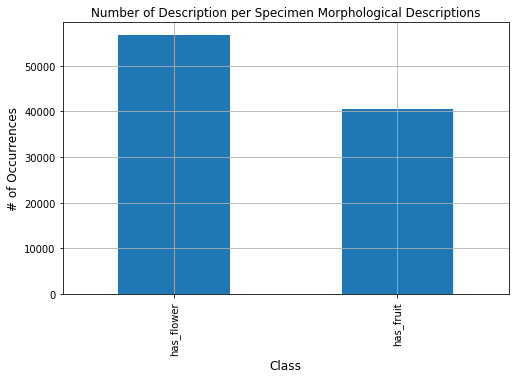

In [6]:
# Plot number of description per specimens' morphological descriptions. 

df_stats.plot(x='category', y='number_of_descriptions', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of Description per Specimen Morphological Descriptions")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)

/home/maria/Applications/anaconda3/envs/ml_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of Categories')

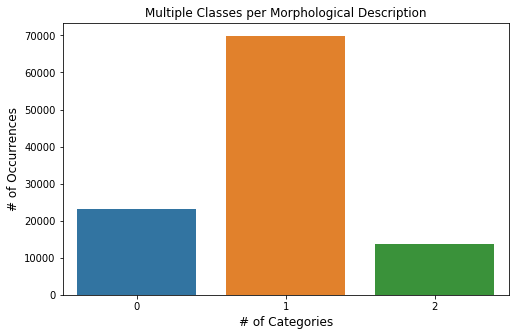

In [7]:
## Plot: specimen morphological descriptions with multiple classes (multi-label).
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple Classes per Morphological Description")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Categories', fontsize=12)

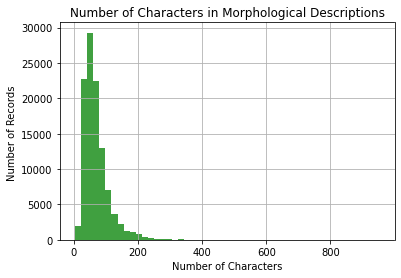

In [8]:
# Plot: number of characters in morphological descriptions.

lens = df.contents.str.len()

# the histogram of the data
n, bins, patches = plt.hist(lens, 50,  facecolor='g', alpha=0.75)


plt.xlabel('Number of Characters')
plt.ylabel('Number of Records ')
plt.title('Number of Characters in Morphological Descriptions')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()


In [9]:
print('Percentage of comments that do not have flowers nor fruits' )
print(len(df[(df['has_flower']==0) & (df['has_fruit']==0)]) / len(df))

Percentage of comments that do not have flowers nor fruits
0.21772592786787012


In [10]:
# Prepare data for experiments. Drop unused columns.
df_X = df.drop(['specimen_id', 'has_flower', 'has_fruit'], axis=1)
df_Y = df.drop(['specimen_id', 'contents'], axis=1)

### Specimens' Morphological Descriptions Classification

The classification objective was to determine if each of the morphological descriptions of
the specimens mentioned or not the presence of flowers or fruits, that is, to assign each
description to the has_flowers and/or has_fruits classes. Each sample could be assigned
to zero, one, or both classes; therefore, the classification problem corresponds to a multi-label classification task. The algorithms Multinomial Naive Bayes (NB) (Klampanos, 2009), Linear Support Vector Classification (SVC) (Chang et al., 2008), and Logistic Regression (LR) (Bishop, 2006) were used for the experiments.

### Naives Bayes
10-fold Cross-Validation and OneVsRest multilabel strategy were used with Naive Bayes to predict the presence of zero, one, or both labels (has-flower and has-fruit) in the morphological descriptions of the specimens. Naive Bayes supports multi-class classification, but in a multi-label scenario to wrapp Naive Bayes in the OneVsRestClassifier is needed.

In [11]:
# Naives Bayes without pipeline

# Vectorize X_train 
X_train = df_X.contents
vectorizer = TfidfVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

# k-fold cross validation
k = 10

for category in categories:
    print('... Processing {}'.format(category))

    # Define the model
    model = MultinomialNB(fit_prior=True, class_prior=None)

    # Define the OneVsRest strategy
    ovr = OneVsRestClassifier(model)

    # Define the test condition with k-fold cross validation
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    
    # Make predictions and compute metrics     
    mean_accuracy, mean_precision, mean_recall, mean_f1 =  evaluate_model_crossValidation(cv, ovr,  X_train_vec, df_Y[category])
    print("Mean accuracy, 10 fold validation", mean_accuracy)
    print("Mean precision, 10 fold validation", mean_precision)
    print("Mean recall, 10 fold validation", mean_recall)
    print("Mean f1, 10 fold validation", mean_f1)

... Processing has_flower
Mean accuracy, 10 fold validation 0.9625950513477852
Mean precision, 10 fold validation 0.946231236047167
Mean recall, 10 fold validation 0.9854723696325438
Mean f1, 10 fold validation 0.9654510928205149
... Processing has_fruit
Mean accuracy, 10 fold validation 0.9759091242210696
Mean precision, 10 fold validation 0.9850740690931559
Mean recall, 10 fold validation 0.951012223838652
Mean f1, 10 fold validation 0.9677423330198461


### LinearSVC (Chang et al., 2008)


In [12]:
# Logistic regression.
# Model evaluated with 10-fold Cross-validation 


#Vectorize X_train 
X_train = df_X.contents
vectorizer = TfidfVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)

# k-fold cross validation
k = 10

for category in categories:
    print('... Processing {}'.format(category))
    # Define the model
    model = LinearSVC()
    
    # Define the OneVsRest strategy
    ovr = OneVsRestClassifier(model)
    
    # Define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Make predictions and compute metrics 
    mean_accuracy, mean_precision, mean_recall, mean_f1 =  evaluate_model_crossValidation(cv, ovr,  X_train_vec, df_Y[category])
    print("Mean accuracy, 10 fold validation", mean_accuracy)
    print("Mean precision, 10 fold validation", mean_precision)
    print("Mean recall, 10 fold validation", mean_recall)
    print("Mean f1, 10 fold validation", mean_f1)

... Processing has_flower
Mean accuracy, 10 fold validation 0.9946444007648431
Mean precision, 10 fold validation 0.9996085488684509
Mean recall, 10 fold validation 0.9902950295367934
Mean f1, 10 fold validation 0.9949294355488545
... Processing has_fruit
Mean accuracy, 10 fold validation 0.995814766288418
Mean precision, 10 fold validation 0.9998762003984082
Mean recall, 10 fold validation 0.9891256301259217
Mean f1, 10 fold validation 0.994471309022652


### Logistic Regression


In [13]:
# Logistic regression.
# Model evaluated with 10-fold Cross-validation 

#Vectorize X_train 
X_train = df_X.contents
vectorizer = TfidfVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)

# k-fold cross validation
k = 10

for category in categories:
    print('... Processing {}'.format(category))
    # Define the model
    model = LogisticRegression(max_iter=150)
    
    # Define the OneVsRest strategy
    ovr = OneVsRestClassifier(model)
    
    # Define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Make predictions and compute metrics 
    mean_accuracy, mean_precision, mean_recall, mean_f1 =  evaluate_model_crossValidation(cv, ovr,  X_train_vec, df_Y[category])
    print("Mean accuracy, 10 fold validation", mean_accuracy)
    print("Mean precision, 10 fold validation", mean_precision)
    print("Mean recall, 10 fold validation", mean_recall)
    print("Mean f1, 10 fold validation", mean_f1)

... Processing has_flower
Mean accuracy, 10 fold validation 0.9888300009081898
Mean precision, 10 fold validation 0.9979176247687882
Mean recall, 10 fold validation 0.9809926106841524
Mean f1, 10 fold validation 0.9893816519269194
... Processing has_fruit
Mean accuracy, 10 fold validation 0.9904123418075501
Mean precision, 10 fold validation 0.9998492860655872
Mean recall, 10 fold validation 0.9749278641675792
Mean f1, 10 fold validation 0.9872295243946232


### References

Bishop C (2006) Pattern Recognition and Machine Learning. . Information Science and
Statistics. Springer.

Brownlee, J. (2020). Multi-Label Classification with Deep Learning. Recovered from https://machinelearningmastery.com/multi-label-classification-with-deep-learning/

Brownlee, J. (2020b). One-vs-Rest and One-vs-One for Multi-Class Classification. Recovered from https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

Brownlee, J. (2020c). How to Configure k-Fold Cross-Validation. https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

Chang K, Hsieh C, Wang X, Lin C (2008) LIBLINEAR: A Library for Large Linear
Classification. Journal of Machine Learning Research 9.

Klampanos I (2009) Manning Christopher, Prabhakar Raghavan, Hinrich Schütze:
Introduction to information retrieval. Information Retrieval 12 (5): 609‑612. https://
doi.org/10.1007/s10791-009-9096-x

Li, S. (218). Multi Label Text Classification with Scikit-Learn
 https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5 
 
Mora-Cross, M., Morales-Carmiol, A., Chen-Huang, T., Barquero-
Pérez, M. (2022). Essential Biodiversity Variables: Extracting Plant Phenological Data from Specimen Labels Using Machine Learning. 

Scikt-learn. Multiclass and multioutput algorithms. Recovered from https://scikit-learn.org/stable/modules/multiclass.html